In [1]:
import torch
import torchvision
import torchvision.models as models
from PIL import Image, ImageFile
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import gc; gc.enable()
import pandas as pd
from torch.utils.data import Dataset
import tensorflow as tf
from tensorflow import keras
from tensorflow.layers import Dense
from torchvision import transforms

In [23]:
# filter warnings
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
# keras imports
# from keras.applications.vgg16 import VGG16, preprocess_input
# from keras.applications.vgg19 import VGG19, preprocess_input
# from keras.applications.xception import Xception, preprocess_input
# from keras.applications.resnet50 import ResNet50, preprocess_input
# from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
# from keras.applications.mobilenet import MobileNet, preprocess_input
# from keras.applications.inception_v3 import InceptionV3, preprocess_input
# from keras.preprocessing import image
from keras.models import Model
from keras.models import model_from_json
from keras.layers import Input
# other imports
from sklearn.preprocessing import LabelEncoder
import numpy as np
import glob
import cv2
import h5py
import os
import json
import datetime
import time
# load the user configs
with open('conf/conf.json') as f:    
    config = json.load(f)
# config variables
model_name = config["model"]
weights = config["weights"]
include_top = config["include_top"]
train_path = config["train_path"]
features_path = config["features_path"]
labels_path = config["labels_path"]
test_size = config["test_size"]
results = config["results"]
model_path = config["model_path"]
# start time
print ("[STATUS] start time - {}".format(datetime.datetime.now().strftime("%Y-%m-%d %H:%M")))
start = time.time()
# create the pretrained models
# check for pretrained weight usage or not
# check for top layers to be included or not
if model_name == "vgg16":
    base_model = VGG16(weights=weights)
    model = Model(input=base_model.input, output=base_model.get_layer('fc1').output)
    image_size = (224, 224)
elif model_name == "vgg19":
    base_model = VGG19(weights=weights)
    model = Model(input=base_model.input, output=base_model.get_layer('fc1').output)
    image_size = (224, 224)
elif model_name == "resnet50":
    base_model = keras.applications.ResNet50(include_top=False, weights=weights)
    model = base_model
#     model = Model(input=base_model.input, output=base_model.layers[-1].output)
    image_size = (224, 224)
elif model_name == "inceptionv3":
    base_model = InceptionV3(include_top=include_top, weights=weights, input_tensor=Input(shape=(299,299,3)))
    model = Model(input=base_model.input, output=base_model.get_layer('custom').output)
    image_size = (299, 299)
elif model_name == "inceptionresnetv2":
    base_model = InceptionResNetV2(include_top=include_top, weights=weights, input_tensor=Input(shape=(299,299,3)))
#     model = Model(input=base_model.input, output=base_model.layers[-1].output)
    image_size = (299, 299)
elif model_name == "mobilenet":
    base_model = MobileNet(include_top=include_top, weights=weights, input_tensor=Input(shape=(224,224,3)), input_shape=(224,224,3))
    model = Model(input=base_model.input, output=base_model.get_layer('custom').output)
    image_size = (224, 224)
elif model_name == "xception":
    base_model = Xception(weights=weights)
    model = Model(input=base_model.input, output=base_model.get_layer('avg_pool').output)
    image_size = (299, 299)
else:
    base_model = None
print ("[INFO] successfully loaded base model and model...")


[STATUS] start time - 2019-08-20 14:46


/Users/flatironschool/.local/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


[INFO] successfully loaded base model and model...


In [ ]:
# path to training dataset
train_labels = os.listdir(train_path)
# encode the labels
print ("[INFO] encoding labels...")
le = LabelEncoder()
le.fit([tl for tl in train_labels])
# variables to hold features and labels
features = []
labels   = []
# loop over all the labels in the folder
count = 1
for i, label in enumerate(train_labels):
    cur_path = train_path + "/" + label
    count = 1
    for image_path in glob.glob(cur_path + "/*.jpg"):
        img = image.load_img(image_path, target_size=image_size)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        feature = model.predict(x)
        flat = feature.flatten()
        features.append(flat)
        labels.append(label)
        print ("[INFO] processed - " + str(count))
        count += 1
    print ("[INFO] completed label - " + label)
# encode the labels using LabelEncoder
le = LabelEncoder()
le_labels = le.fit_transform(labels)
# get the shape of training labels
print ("[STATUS] training labels: {}".format(le_labels))
print ("[STATUS] training labels shape: {}".format(le_labels.shape))
# save features and labels
h5f_data = h5py.File(features_path, 'w')
h5f_data.create_dataset('dataset_1', data=np.array(features))
h5f_label = h5py.File(labels_path, 'w')
h5f_label.create_dataset('dataset_1', data=np.array(le_labels))
h5f_data.close()
h5f_label.close()
# save model and weights
model_json = model.to_json()
with open(model_path + str(test_size) + ".json", "w") as json_file:
    json_file.write(model_json)
# save weights
model.save_weights(model_path + str(test_size) + ".h5")
print("[STATUS] saved model and weights to disk..")
print ("[STATUS] features and labels saved..")
# end time
end = time.time()
print ("[STATUS] end time - {}".format(datetime.datetime.now().strftime("%Y-%m-%d %H:%M")))

In [2]:
def getRadius(img):
#     print(type(img.shape))
    circles = cv2.HoughCircles(img,3,1,max(img.shape)/2,param1=50,param2=30,minRadius= int(max(img.shape)/6),maxRadius=max(img.shape))
    return circles[0][0][2]

In [3]:
original_dataset_dir = '/Users/flatironschool/Documents/Kaggle/Kaggle-DR-detection/'
train_dir = original_dataset_dir+'train_images/'
#read in table with image ids and retinopathy severity rating for associated image
labels = pd.read_csv(original_dataset_dir + 'train.csv')

In [4]:
#one-hot encode retinopathy severity
pd_diagnoses = pd.get_dummies(labels['diagnosis'])

In [5]:
diagnoses = keras.utils.to_categorical(labels['diagnosis'])

In [6]:
labels_minus_diagnosis = labels.drop(columns = ['diagnosis'])
dummy_labels = pd.concat([labels_minus_diagnosis,pd_diagnoses], axis = 1)

In [24]:
dummy_labels.head()

,0,1,2,3,4
id_code,,,,,
000c1434d8d7,0,0,1,0,0
001639a390f0,0,0,0,0,1
0024cdab0c1e,0,1,0,0,0
002c21358ce6,1,0,0,0,0
005b95c28852,1,0,0,0,0


In [7]:
dummy_labels=dummy_labels.set_index('id_code')

In [8]:
t = dummy_labels.transpose()
t_dict = t.to_dict()

In [9]:
sm_path = train_dir + '/sm'
imgs = {}

In [10]:
smudge = []

In [11]:
for img in os.listdir(train_dir):
    if img.endswith('.png'):
        img_array = cv2.imread(os.path.join(train_dir,img))
        #crop each image to 80% of fundus diameter
        try:
            r = getRadius(img_array)
            crop_r = round(r*0.8) 
        except:
            crop_r = (img_array.shape[1]/2)*0.8
            
        center_x = int(img_array.shape[1]/2)
        center_y = int(img_array.shape[0]/2)
    
        left_border = int(center_x - crop_r)
        right_border = int(center_x + crop_r)
        upper_border = int(center_y - crop_r)
        lower_border = int(center_y + crop_r)
    
        if left_border < 0:
            difference = 0- left_border
            left_border = 0
            right_border -=difference
            upper_border += difference
            lower_border -= difference
        if upper_border < 0:
            difference = 0- upper_border
            upper_border = 0
            lower_border -= difference
            left_border += difference
            right_border -= difference

        cropped = img_array[upper_border:lower_border, left_border:right_border]
        #resize image to resnet's expected input size
        a = cv2.resize(cropped, (224,224), interpolation = cv2.INTER_CUBIC)
#         lab = cv2.cvtColor(a, cv2.COLOR_BGR2LAB)
#         lab_planes = cv2.split(lab)
#         clahe = cv2.createCLAHE(clipLimit= 1,tileGridSize=(round(a.shape[0]/6),round(a.shape[1]/6)))
#         lab_planes[0] = clahe.apply(lab_planes[0])
#         lab = cv2.merge(lab_planes)
#         a = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
       
#         a =cv2.medianBlur(a,5)
#         a=cv2.addWeighted(a, 4, cv2.GaussianBlur(a,(0,0), 30), -4, 128)
        a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
        imgs[img[:-4]] = a
        gc.collect()
    
#         os.chdir(sm_path)
#         cv2.imwrite("sm"+"_"+img ,a)
#         os.chdir(path)   
#     print(ctr)

In [12]:
#generate arrays so that severity ratings have same order as their associated images
ordered_imgs = []
label_vectors = []
for key in imgs.keys():
    ordered_imgs.append(imgs[key])
    lbls = []
    for k in t_dict[key]:
        lbls.append(t_dict[key][k])
    label_vectors.append(lbls)


In [64]:
bleh_norm = bleh/255
b_cov = np.cov(bleh_norm, rowvar = True)
U, S, V = np.linalg.svd(b_cov)
epsilon = 0.1
b_ZCA = U.dot(np.diag(1.0/np.sqrt(S+epsilon))).dot(U.T).dot(bleh_norm)
bleh_ZCA_rescaled = (b_ZCA - b_ZCA.min())/(b_ZCA.max()-b_ZCA.min())

In [21]:
npimgs = np.asarray(imgs)

In [22]:
stacks = [npimgs[np.random.choice(npimgs.shape[0],len(npimgs)//10, replace = False)] for a in range(11)]

In [15]:
comps = []
epsilon = 0.1

for stack in stacks:
    X = stack.reshape(stack.shape[0], stack.shape[1]*stack.shape[2]*stack.shape[3])
    X_norm = X/255
    cov = np.cov(X_norm, rowvar=True)
    U,S,V = np.linalg.svd(cov)
    comps.append((U,S))


In [17]:
X_ZCA = U.dot(np.diag(1.0/np.sqrt(S + epsilon))).dot(U.T).dot(X_norm)


(366, 786432)


In [22]:
X_ZCA_rescaled = (X_ZCA - X_ZCA.min()) / (X_ZCA.max() - X_ZCA.min())

In [35]:
X_ZCA_rescaled.shape

(366, 786432)

In [29]:
for u in range(70,70+X_ZCA_rescaled.shape[0]//10):
    b= X_ZCA_rescaled[u].reshape(512,512,3)
    c = cv2.cvtColor(b, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(c,100,200)
    plt.imshow(edges)
    plt.show()

error: OpenCV(4.1.0) /Users/travis/build/skvark/opencv-python/opencv/modules/imgproc/src/color.simd_helpers.hpp:94: error: (-2:Unspecified error) in function 'cv::impl::(anonymous namespace)::CvtHelper<cv::impl::(anonymous namespace)::Set<3, 4, -1>, cv::impl::(anonymous namespace)::Set<1, -1, -1>, cv::impl::(anonymous namespace)::Set<0, 2, 5>, cv::impl::(anonymous namespace)::SizePolicy::NONE>::CvtHelper(InputArray, OutputArray, int) [VScn = cv::impl::(anonymous namespace)::Set<3, 4, -1>, VDcn = cv::impl::(anonymous namespace)::Set<1, -1, -1>, VDepth = cv::impl::(anonymous namespace)::Set<0, 2, 5>, sizePolicy = cv::impl::(anonymous namespace)::SizePolicy::NONE]'
> Unsupported depth of input image:
>     'VDepth::contains(depth)'
> where
>     'depth' is 6 (CV_64F)


In [13]:
#instantiate pre-trained ResNet model
res_fifty = keras.applications.ResNet50(include_top=False, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)

Instructions for updating:
Colocations handled automatically by placer.


/Users/flatironschool/.local/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [14]:
datagen = keras.preprocessing.image.ImageDataGenerator(rotation_range = 180,horizontal_flip = True, vertical_flip = True,data_format = 'channels_last')
batch_size = 20
# datagen.fit(ordered_imgs)
 
train_generator = datagen.flow(
    np.asarray(ordered_imgs),
    label_vectors,
    batch_size=batch_size,
    shuffle = False)

In [16]:
train_features = np.zeros(shape=(len(ordered_imgs), 7, 7, 2048))
train_labels = np.zeros(shape=(len(ordered_imgs),5))

In [25]:
i = 0
for inputs_batch, labels_batch in train_generator:
    features_batch = res_fifty.predict(inputs_batch)
    train_features[i * batch_size : (i + 1) * batch_size] = features_batch
    train_labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= len(ordered_imgs):
        break
         
# train_features = np.reshape(train_features, (len(ordered_imgs), 7 * 7 * 2048))

(20, 7, 7, 2048)
(20, 7, 7, 2048)
(20, 7, 7, 2048)
(20, 7, 7, 2048)
(20, 7, 7, 2048)
(20, 7, 7, 2048)
(20, 7, 7, 2048)
(20, 7, 7, 2048)
(20, 7, 7, 2048)
(20, 7, 7, 2048)
(20, 7, 7, 2048)
(20, 7, 7, 2048)
(20, 7, 7, 2048)
(20, 7, 7, 2048)
(20, 7, 7, 2048)
(20, 7, 7, 2048)
(20, 7, 7, 2048)
(20, 7, 7, 2048)
(20, 7, 7, 2048)
(20, 7, 7, 2048)
(20, 7, 7, 2048)
(20, 7, 7, 2048)
(20, 7, 7, 2048)
(20, 7, 7, 2048)
(20, 7, 7, 2048)
(20, 7, 7, 2048)
(20, 7, 7, 2048)
(20, 7, 7, 2048)
(20, 7, 7, 2048)
(20, 7, 7, 2048)
(20, 7, 7, 2048)
(20, 7, 7, 2048)
(20, 7, 7, 2048)
(20, 7, 7, 2048)
(20, 7, 7, 2048)
(20, 7, 7, 2048)
(20, 7, 7, 2048)
(20, 7, 7, 2048)
(20, 7, 7, 2048)
(20, 7, 7, 2048)
(20, 7, 7, 2048)
(20, 7, 7, 2048)
(20, 7, 7, 2048)
(20, 7, 7, 2048)
(20, 7, 7, 2048)
(20, 7, 7, 2048)
(20, 7, 7, 2048)
(20, 7, 7, 2048)
(20, 7, 7, 2048)
(20, 7, 7, 2048)
(20, 7, 7, 2048)
(20, 7, 7, 2048)
(20, 7, 7, 2048)
(20, 7, 7, 2048)
(20, 7, 7, 2048)
(20, 7, 7, 2048)
(20, 7, 7, 2048)
(20, 7, 7, 2048)
(20, 7, 7, 204

In [37]:
from sklearn.multiclass import OutputCodeClassifier as occ
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

features_train, features_test, labels_train, labels_test = train_test_split(train_features,labels,test_size = 0.2)
clf = occ(SVC(random_state=69), random_state= 420)
clf.fit(features_train, labels_train['diagnosis'])


ValueError: Found array with dim 4. Estimator expected <= 2.

In [27]:
h5f_data = h5py.File(features_path, 'w')
h5f_data.create_dataset('dataset_1', data=np.array(features))
# h5f_label = h5py.File(labels_path, 'w')
# h5f_label.create_dataset('dataset_1', data=np.array(le_labels))
h5f_data.close()
# h5f_label.close()
# save model and weights
model_json = model.to_json()
with open(model_path + str(test_size) + ".json", "w") as json_file:
    json_file.write(model_json)
# save weights
model.save_weights(model_path + str(test_size) + ".h5")

OSError: Unable to create file (unable to open file: name = 'output/DR/resnet50/features.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 602)

In [38]:
features_train.shape

(2929, 7, 7, 2048)

(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)


/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)
(7, 7, 2048)
(7, 7)


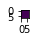

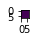

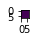

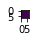

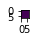

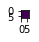

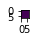

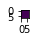

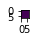

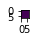

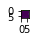

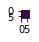

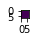

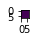

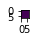

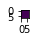

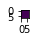

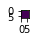

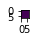

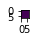

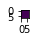

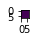

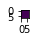

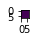

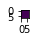

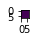

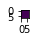

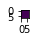

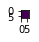

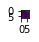

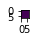

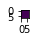

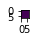

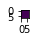

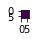

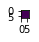

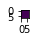

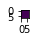

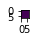

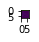

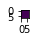

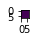

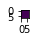

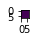

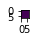

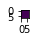

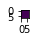

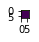

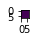

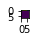

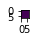

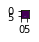

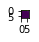

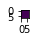

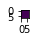

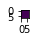

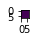

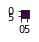

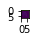

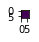

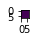

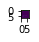

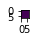

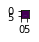

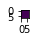

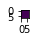

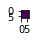

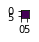

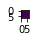

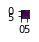

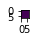

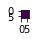

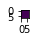

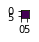

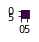

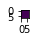

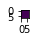

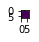

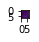

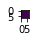

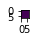

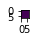

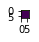

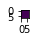

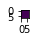

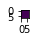

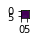

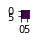

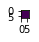

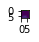

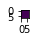

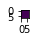

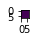

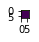

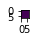

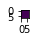

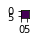

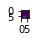

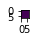

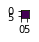

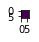

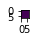

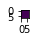

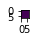

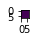

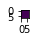

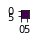

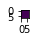

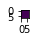

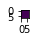

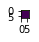

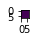

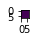

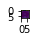

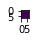

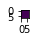

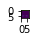

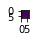

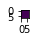

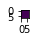

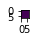

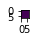

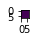

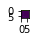

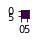

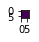

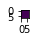

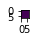

In [58]:
images_per_row = 16

# for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
n_features = train_features.shape[-1] # Number of features in the feature map
size = train_features.shape[1] #The feature map has shape (1, size, size, n_features).

n_cols = n_features // images_per_row # Tiles the activation channels in this matrix

display_grid = np.zeros((size * n_cols, images_per_row * size))
for col in range(n_cols): # Tiles each filter into a big horizontal grid
    for row in range(images_per_row):
            print(train_features[3].shape)
            channel_image = train_features[3][:, :, col * images_per_row + row]
            print(channel_image.shape)
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            break    
    scale = 1. / size
    plt.figure(figsize=(scale,scale))
    plt.imshow(channel_image, aspect='auto', cmap='viridis')
    

In [110]:
res_fifty.add(Dense(5))

AttributeError: 'Model' object has no attribute 'add'

In [1]:
res_fifty.compile(loss= 'categorical_crossentropy',optimizer = 'adam')

NameError: name 'res_fifty' is not defined

In [109]:
res_fifty.fit(np.asarray(ordered_imgs),np.asarray(label_vectors))

Instructions for updating:
Use tf.cast instead.


InvalidArgumentError: Incompatible shapes: [1,5] vs. [1,7,7,2048]
	 [[{{node training/Adam/gradients/loss_1/activation_48_loss/mul_grad/BroadcastGradientArgs}}]]